# **Exploratory Data Analysis**: FlipTop

## Question
----

The central question of this project revolves around FlipTop battle rap careers and their length.

> How long does a career in the Philippines' premier rap battle league FlipTop last?

Who rises to the top? What determines who stays relevant over the years?

Here I'm thinking survival (time-to-event) analysis.

Another question I'm curious about is this:
> Who has battled who? And what matchups haven't been done yet?

I'm picturing a graph here. I want to understand how dense or sparse the network of rap battles are in FlipTop.

Ideas:
- Emcees are nodes
- "Battled" as edges
- Weight of the edge is how many times they've battled?

## Data Wrangling
----

Data wrangled using [YouTube API](https://developers.google.com/youtube/v3).

In [1]:
import sys
import json
import pandas as pd
import numpy as np
import isodate
import re
from datetime import timedelta
from dateutil import parser as dateparse

In [2]:
import sys
from pathlib import Path

# project_root is the parent of the notebooks/ folder
PROJECT_ROOT = Path.cwd().parent
SCRIPTS_DIR = PROJECT_ROOT / "scripts"

# make project root importable
sys.path.insert(0, str(PROJECT_ROOT))

# sanity check
assert (SCRIPTS_DIR / "battle_metadata_scraper.py").exists(), "Can't find battle_metadata_scraper.py under scripts/"

from scripts.battle_metadata_scraper import scrape_year, scrape_years


Note: This data was scraped July 2, 2025.
- Update: Channel data was scraped again August 26, 2025.
- Update: Channel data was scraped again October 7, 2025.

In [3]:
# Load JSON data
with open("../data/videos.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)

# Preview
df.head()

,id,title,description,upload_date,view_count,duration,url,likeCount,commentCount,tags
0,NCElL6MbZ_g,FlipTop - Caspher vs CRhyme,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-07-02T13:23:54Z,139884,PT32M32S,https://www.youtube.com/watch?v=NCElL6MbZ_g,3117,613,"[fliptop, flip top, flip top battles, fliptopb..."
1,JabvhPBmoVs,FlipTop CripLi - Isabuhay 2025 | Abangan si Cr...,"FlipTop presents: Gubat 15 @ Mariner's Court, ...",2025-06-25T13:49:25Z,27498,PT1M51S,https://www.youtube.com/watch?v=JabvhPBmoVs,640,31,"[fliptop, flip top, flip top battles, fliptopb..."
2,YiJI_ohq4Pc,FlipTop Ban - Isabuhay 2025 | Abangan si Ban n...,"FlipTop presents: Gubat 15 @ Mariner's Court, ...",2025-06-25T13:49:25Z,29353,PT1M24S,https://www.youtube.com/watch?v=YiJI_ohq4Pc,763,34,"[fliptop, flip top, flip top battles, fliptopb..."
3,yRE3PU0ekaA,FlipTop J-Blaque - Gods Pa Rin? | | Abangan si...,"FlipTop presents: Gubat 15 @ Mariner's Court, ...",2025-06-25T13:49:25Z,17415,PT1M56S,https://www.youtube.com/watch?v=yRE3PU0ekaA,360,8,"[fliptop, flip top, flip top battles, fliptopb..."
4,Ftk2DZ3hcxw,FlipTop Vitrum - Ang HipHop Pinalakas ng mga T...,"FlipTop presents: Gubat 15 @ Mariner's Court, ...",2025-06-25T13:48:58Z,28969,PT3M15S,https://www.youtube.com/watch?v=Ftk2DZ3hcxw,449,50,"[fliptop, flip top, flip top battles, fliptopb..."


In [ ]:
# # No need to run this again (already ran once and wrote to file)
# sys.path.append("../scripts")

# from emcee_scraper import scrape_names, write_names_to_csv
# emcees = scrape_names()
# write_names_to_csv(emcees, "../data/emcees.csv")

## Data Cleaning
----

Tasks:

- convert `upload_date` to something more usable.
- convert `duration` to human readable (HH:MM:SS maybe?)
- Some shorts/round highlight moments were uploaded on the [videos playlist](https://www.youtube.com/@fliptopbattles/videos) of the channel so need to filter by duration, especially post-2020 (when YouTube Shorts became a thing).
- Only considering 1v1 battles that were judged (for now)
    - So remove:
        - Sound Check
        - Freestyle battles
        - Dos Por Dos (2v2)
        - Royal Rumble (1v1v1v1v1)
        - Those two 5v5 battles that happened only twice
        - Anygma Machine
        - Video Flyer
        - Announcement videos
        - Emcee interview videos

BIG TASKS

- Clean up `title` and create new column `battle_card` or something that contains only names e.g. Emcee1 vs Emcee2
- Webscrape [emcee page](https://www.fliptop.com.ph/emcees) to get a full and complete list of the emcees in FlipTop (according to their own website roster).
    - Good for later user of cross-referencing titles with emcee names.

In [4]:
df.head()

,id,title,description,upload_date,view_count,duration,url,likeCount,commentCount,tags
0,NCElL6MbZ_g,FlipTop - Caspher vs CRhyme,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-07-02T13:23:54Z,139884,PT32M32S,https://www.youtube.com/watch?v=NCElL6MbZ_g,3117,613,"[fliptop, flip top, flip top battles, fliptopb..."
1,JabvhPBmoVs,FlipTop CripLi - Isabuhay 2025 | Abangan si Cr...,"FlipTop presents: Gubat 15 @ Mariner's Court, ...",2025-06-25T13:49:25Z,27498,PT1M51S,https://www.youtube.com/watch?v=JabvhPBmoVs,640,31,"[fliptop, flip top, flip top battles, fliptopb..."
2,YiJI_ohq4Pc,FlipTop Ban - Isabuhay 2025 | Abangan si Ban n...,"FlipTop presents: Gubat 15 @ Mariner's Court, ...",2025-06-25T13:49:25Z,29353,PT1M24S,https://www.youtube.com/watch?v=YiJI_ohq4Pc,763,34,"[fliptop, flip top, flip top battles, fliptopb..."
3,yRE3PU0ekaA,FlipTop J-Blaque - Gods Pa Rin? | | Abangan si...,"FlipTop presents: Gubat 15 @ Mariner's Court, ...",2025-06-25T13:49:25Z,17415,PT1M56S,https://www.youtube.com/watch?v=yRE3PU0ekaA,360,8,"[fliptop, flip top, flip top battles, fliptopb..."
4,Ftk2DZ3hcxw,FlipTop Vitrum - Ang HipHop Pinalakas ng mga T...,"FlipTop presents: Gubat 15 @ Mariner's Court, ...",2025-06-25T13:48:58Z,28969,PT3M15S,https://www.youtube.com/watch?v=Ftk2DZ3hcxw,449,50,"[fliptop, flip top, flip top battles, fliptopb..."


Video descriptions often have good info on them for when and where the rap battle took place. Need to scrape these too!
- Let's put a pin on that right now. Do low-hanging fruit first before going for messy regex text extraction tasks.

In [5]:
def clean_titles(df: pd.DataFrame) -> pd.DataFrame:
    """Trim whitespace and remove wrapping double quotes in 'title' column."""
    return (
        df.assign(
            title=df['title']
            .str.strip()
            .str.replace(r'^"(.*)"$', r"\1", regex=True)
        )
    )

In [6]:
def parse_upload_date(df: pd.DataFrame) -> pd.DataFrame:
    """
    Parse 'upload_date' into datetime object (UTC).
    """
    if "upload_date" not in df:
        return df
    else:
        return (
            df.assign(
                upload_date = lambda d: pd.to_datetime(d["upload_date"], errors="coerce", utc=True)
            )
        )

In [7]:
def add_duration_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    From ISO-8601 'duration' strings create:
      - 'duration_seconds'  (numeric)
      - 'duration_timedelta' (Timedelta, good for math)
      - 'duration_hms'      (string 'HH:MM:SS' for display)
    """
    if "duration" not in df:
        return df

    def to_seconds(x):
        if pd.isna(x):
            return pd.NA
        try:
            d = isodate.parse_duration(x)
            if isinstance(d, timedelta):            
                return d.total_seconds()
            return d.totimedelta().total_seconds()
        except Exception:
            return pd.NA

    seconds = df["duration"].map(to_seconds)
    td = pd.to_timedelta(seconds, unit="s")

    hms = pd.to_datetime(seconds, unit="s").dt.strftime("%H:%M:%S")
    hms = hms.where(seconds.notna(), other=pd.NA)

    return df.assign(
        duration_seconds=seconds,
        duration_timedelta=td,
        duration_hms=hms,
    )

In [8]:
def convert_video_metrics_to_numeric(df: pd.DataFrame) -> pd.DataFrame:
    """
    Columns like 'view_count', 'likeCount', and 'commentCount' are strings. This function turns them into numbers.
    """
    target_cols = ["view_count", "likeCount", "commentCount"]
    present_cols = [col for col in target_cols if col in df]
    if not present_cols:
        return df
    return (
        df.assign(
            **{col: pd.to_numeric(df[col], errors="coerce") for col in present_cols}
        )
    )

Next task:
- Subset `df` to only include 1v1 battles.

While the majority of the videos posted on the [FlipTop YouTube channel](https://www.youtube.com/@fliptopbattles) are rap battles, a number of them are video flyers, announcement videos, behind-the-scenes content, reaction videos, and the like. As such, it's important to filter out these videos so that we're left to analyze the data from the **rap battles** alone.

### But what constitutes a **rap battle**?

Good question.

My criteria for what is considered a rap battle for the purposes of this project:
1. The video needs to be *a capella* (no underlying beat to accompany emcees rapping).
2. The video involves emcees performing written material (not all of their rounds are off-the-top freestyle). 
    - The early days of FlipTop saw emcees testing each other's skills in the artform known as off-the-top freestyle, where emcees would take turns berating each other lyrically with material they thought of on the spot or in the moment of speaking. 
3. To a lesser extent, the video needs to involve judging at the end (there needs to be stakes).

Note:
- **By these criteria, earlier videos of FlipTop wouldn't be included. Need explanation for what I'm doing here.**
    - I've changed my mind on this. I've included them alongside the freestyle battles whether a capella or with a beat.

As a long-time viewer of these videos, there's a couple key words that makes filtering with these criteria in mind easier. 
- Include:
    - **vs** - most, if not all, of the a capella rap battles in the FlipTop YouTube channel have "vs" in the video title. 
        - For the uninitiated: "vs" is short for "versus." 
- Exclude:
    - **tryout** - while these are battles, they are for the newcomers to the scene and is often not judged, especially in older videos.
    - **beatbox** - this is another genre of battle separate from the a capella, judged battles.
    - **flyer** and **promo** - these are advertisements and announcement videos for upcoming events.
    - **Anygma Machine** - Anygma, the head of FlipTop as a company, sometimes reviews battles and gives his take on upcoming matches.
        - A reference to the real [Enigma Machine](https://en.wikipedia.org/wiki/Enigma_machine) that the allies had to break in WW2.
   - **[LIVE]** - live performances from the FlipTop Festival event that happened in 2020.
   - **UnggoYan** - Emcees read comments left on videos of their previous battles
   - **Pre-Battle Interviews** - self-explanatory
   - **Salitang Ugat** - translation: "root word." These are interviews of notable emcees who tell the stories behind how they came up with their rap battle name.
   - **Trailer** - promo video trailer for upcomming events
   - **Video Flyer** - self-explanatory
   - **Silip** - BTS videos added recently
   - **Sound Check** - Pre-event check in with FlipTop event prep stuff
   - **Tribute** - tribute to dead rappers
   - **Tutok** - other BTS videos?
   - **Abangan** - clips

For the scope of this project, I will only consider the battles that are between two people. FlipTop has a variety of rap battle formats, not just two people insulting each other back and forth. Examples include: the Royal Rumble, the 5 vs 5, and the tag-team 2 vs 2 (Dos Por Dos) matches. The vast majority of the battles, though, are one versus one. Those battles will be the focus of this project.

In [9]:
def filter_titles_with_vs(df: pd.DataFrame) -> pd.DataFrame:
    """
    Only keep rows in the DataFrame whose 'title' column contains the token "vs" (case-insensitive).
    """
    if "title" not in df:
        return df
    else:
        return (
            df[df['title'].str.contains(r"\bvs\b", case=False, regex=True, na=False)]
        )

In [10]:
EXCLUDE_KEYWORDS = [
    "tryout","tryouts","beatbox","beat box","flyer","promo","promos",
    "anygma machine","unggoyan","pre-battle interviews","interview","interviews",
    "salitang ugat","trailer","video flyer","[live]","silip","sound check",
    "tribute","anniversary party","tutok","review","abangan"
]

EXCLUDE_RE = re.compile("|".join(re.escape(w) for w in EXCLUDE_KEYWORDS), flags=re.IGNORECASE)

def drop_non_battles(df: pd.DataFrame) -> pd.DataFrame:
    """Drop rows whose 'title' matches known non-battle keywords."""
    if "title" not in df:
        return df
    return df[~df["title"].str.contains(EXCLUDE_RE, na=False)]

In [11]:
def keep_1v1(df: pd.DataFrame) -> pd.DataFrame:
    """
    Keep rows in the DataFrame that look like 1v1 battles based on simple heuristics.
    """
    if "title" not in df:
        return df

    # Defensive: mark non-strings to exclude (to match original behavior)
    is_str = df["title"].apply(lambda x: isinstance(x, str))

    # Lowercase string titles; non-strings become NaN after .str ops
    s = df["title"].where(is_str, None).fillna("").str.lower()

    vs_count  = s.str.count(r"\bvs\b")
    and_count = s.str.count(r"\band\b")
    has_slash = s.str.contains(r"/", na=False)
    has_plus  = s.str.contains(r"\+", na=False)
    and_both  = s.str.contains(r"\band\b.*\bvs\b.*\band\b", na=False)
    n_on_m    = s.str.contains(r"\b\d+\s*on\s*\d+\b", na=False)

    not_1v1 = (
        (~is_str) |
        (vs_count > 1) |
        (and_count > 1) |
        has_slash |
        has_plus  |
        and_both  |
        n_on_m
    )

    return df.loc[~not_1v1]

Next task: deal with early FlipTop battles having parts `pt. 1` and `pt. 2` etc.
- Make it into 1 video but now the links are a list instead of only string?

In [12]:
# keep your existing capturing pattern (used by helpers)
_PT_RE = re.compile(r"\s*pt\.?\s*(\d+)$", flags=re.IGNORECASE)

# NEW: non-capturing suffix pattern for .str.contains
_PT_SUFFIX = re.compile(r"\s*pt\.?\s*\d+$", flags=re.IGNORECASE)

def _base_title(s: str) -> str:
    return _PT_RE.sub("", s.strip()).strip()

def _part_num(s: str) -> int | None:
    m = _PT_RE.search(s)
    return int(m.group(1)) if m else None

def consolidate_battle_parts(df: pd.DataFrame) -> pd.DataFrame:
    if "title" not in df:
        return df

    work = df.copy()
    for c in ("view_count", "likeCount", "commentCount"):
        if c in work:
            work[c] = pd.to_numeric(work[c], errors="coerce")

    # CHANGE THIS LINE: use the non-capturing pattern
    is_part = work["title"].fillna("").str.contains(_PT_SUFFIX, na=False)

    parts = work.loc[is_part].copy()
    if parts.empty:
        return df

    parts["base_title"] = parts["title"].map(_base_title)
    parts["part_num"]   = parts["title"].map(_part_num)
    parts = parts.sort_values(["base_title", "part_num", "title"])

    has_secs = "duration_seconds" in parts

    agg = {
        "description": "first",
        "upload_date": "min",
        "url":        list,
        "id":         list,
        "tags":       lambda x: list({t for ts in x for t in (ts or [])}),
        "view_count": "sum",
        "likeCount":  "sum",
        "commentCount": "sum",
    }
    if has_secs:
        agg["duration_seconds"] = "sum"

    grouped = parts.groupby("base_title", as_index=False).agg(agg)

    if has_secs:
        seconds = grouped["duration_seconds"]
        grouped["duration_timedelta"] = pd.to_timedelta(seconds, unit="s")
        hms = pd.to_datetime(seconds, unit="s").dt.strftime("%H:%M:%S")
        grouped["duration_hms"] = hms.where(seconds.notna(), other=pd.NA)

    grouped = grouped.rename(columns={"base_title": "title"})
    remaining = work.loc[~is_part].copy()
    final_df = pd.concat([remaining, grouped], ignore_index=True)
    return final_df


In [13]:
_VS_SPLIT = re.compile(r"\s+vs\s+", flags=re.IGNORECASE)
_PREFIX = re.compile(r'^FlipTop(?: [^–-]+)?\s*[-–]\s*', flags=re.IGNORECASE)
_POST2 = re.compile(r'\s*[@|(*].*$')     # trim stuff like " @channel", " | something", " (desc", "*whatever"
_TRAIL_NUM = re.compile(r'\s+\d+$')      # trailing stand-alone numbers

def extract_matchup_from_title(title: str) -> str | None:
    """
    Extract a clean 'Emcee A vs Emcee B' string from a FlipTop video title.

    Steps:
      1) Trim whitespace.
      2) Remove an optional leading 'FlipTop … – ' or 'FlipTop … - ' prefix.
      3) Find a single 'vs' (case-insensitive) as the delimiter and split once.
      4) Left side → emcee1 (stripped).
      5) Right side → emcee2 (stripped), then drop trailing clutter that often
         follows names: anything starting with '@', '|', '(' or '*', and any
         trailing standalone number (e.g., ' 2').
      6) If either side ends up empty, return None; otherwise return
         'emcee1 vs emcee2'.
    """
    if not isinstance(title, str):
        return None
    t = title.strip()
    t = _PREFIX.sub("", t)
    parts = _VS_SPLIT.split(t, maxsplit=1)
    if len(parts) != 2:
        return None
    emcee1 = parts[0].strip()
    emcee2 = _POST2.sub("", parts[1].strip())
    emcee2 = _TRAIL_NUM.sub("", emcee2).strip()
    if not emcee1 or not emcee2:
        return None
    return f"{emcee1} vs {emcee2}"


In [14]:
def add_matchup_and_split(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add 'matchup', 'emcee1', and 'emcee2' columns inferred from 'title'.
    - Makes a copy of the input DataFrame.
    - Builds 'matchup' by applying `extract_matchup_from_title` to 'title'.
    - Removes any trailing ' - …' annotation from 'matchup' (e.g., ' - Finals').
    - Splits 'matchup' at the 'vs' boundary into 'emcee1' and 'emcee2'.
    - Strips surrounding whitespace from the resulting name columns.
    """
    if "title" not in df:
        return df
    out = df.copy()
    out["matchup"] = out["title"].map(extract_matchup_from_title)
    # remove trailing " - anything" after matchup, as you did
    out["matchup"] = out["matchup"].str.replace(r'\s-\s.*$', '', regex=True)
    # split into emcee1/emcee2
    split = out["matchup"].str.split(_VS_SPLIT, n=1, expand=True)
    out[["emcee1", "emcee2"]] = split
    # final tidy
    out["emcee1"] = out["emcee1"].str.strip()
    out["emcee2"] = out["emcee2"].str.strip()
    return out

What to do about well-known emcees that have battled under aliases (not their usually emcee names)?
- Poison13 as Markong Bungo
- Tipsy D as Freak Sanchez
- Goriong Talas as Ghostly
- Emar Industriya as No. 144
- Sayadd as Carlito

I've decided to do away with these gimmick aliases. At the end of the day, what I'm interested in is the careers of the *people* behind the personas. I will count these battles as battles under their main emcee names. Not the aliases.

An outline of how I standardized the names:
- I took each emcee's most recent name if they had more than one spelling of their name or if they renamed themselves over time.
- Aesthetically speaking, I arbitrarily picked whichever name looks more appealing to me e.g. "Daddy Joe D" vs "Daddie Joe D" vs "DaddieJoe D"
- I cross-referenced less well-known emcees who have changed their names over the years by comparing faces across the videos.

In [15]:
rename_dict = {
    "Daddie Joe D": "Daddy Joe D",
    "DaddyJoe D": "Daddy Joe D",
    "D.O.C. Pau": "Doc Pau",
    "DOC Pau": "Doc Pau",
    "Damnsa": "Damsa",
    "Pareng Elbiz": "Elbiz",
    "Flip": "Flipzydot1",
    "Frooztreitted Hoemmizyd": "Frooz",
    "GusTav": "Gustav",
    "Hallucinate": "Kris Delano",
    "Ice Rocks": "Saint Ice",
    "J Skeelz": "J-Skeelz",
    "Japormz": "Jhapormz",
    "JayTee": "Jaytee",
    "joshG": "Josh G",
    "JoshG": "Josh G",
    "Juan Lazy": "Juan Tamad",
    "Hearty Tha Bomb": "Hearty",
    "Mac-T": "Mac T",
    "Malupet": "Malupit",
    "Marshall": "Marshall Bonifacio",
    "Mel Christ": "Melchrist",
    "MelChrist": "Melchrist",
    "Nerdskillz": "Nerd Skillz",
    "One3D": "One3d",
    "Poison 13": "Poison13",
    "B.I.L.L.Y.": "Prosecutor Billy",
    "R Zone": "R-Zone",
    "RanieBoy": "Ranieboy",
    "Righteous-One": "Righteous One", 
    "Righteous1": "Righteous One",
    "Single Shot": "SingleShot",
    "Spade": "Goriong Talas",
    "Stiffler": "Stiff",
    "Tim aka Cleave Heckler": "Tim",
    "W-Beat": "W Beat",
    "WBeat": "W Beat",
    "Young One": "YoungOne",
    "2Khelle": "2khelle",
    "Akt": "AKT",
    "Crhyme": "CRhyme",
    "Markong Bungo": "Poison13",
    "Freak Sanchez": "Tipsy D",
    "Ghostly": "Goriong Talas",
    "No. 144": "Emar Industriya",
    "Carlito": "Sayadd",
    "sKarm": "Skarm",
    "Cripli": "CripLi",
    "M-Zhayt": "M Zhayt",
    "Jdee": "JDee",
    "Mastafeat": "MastaFeat",
    "Cnine": "CNine",
    "Sinagtala": "GL",
    "1ce Water": "J-Blaque"
}

In [16]:
def load_rename_map(path: str) -> dict:
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def apply_emcee_rename(df: pd.DataFrame, rename_map: dict) -> pd.DataFrame:
    """
    Canonicalize emcee names using an alias->canonical mapping.
    - Applies to both emcee1 and emcee2.
    - Trims whitespace before/after.
    - Idempotent: re-running won’t change already-canonical names.
    """
    if not {"emcee1","emcee2"} <= set(df.columns):
        return df
    out = df.copy()
    out["emcee1"] = out["emcee1"].astype("string").str.strip().replace(rename_map)
    out["emcee2"] = out["emcee2"].astype("string").str.strip().replace(rename_map)

    return out

def add_matchup_clean(df: pd.DataFrame) -> pd.DataFrame:
    """
    Build 'matchup_clean' from canonicalized emcee columns.
    """
    if not {"emcee1","emcee2"} <= set(df.columns):
        return df
    
    return df.assign(
        matchup_clean=(df["emcee1"].astype("string").str.strip()
                       + " vs " +
                       df["emcee2"].astype("string").str.strip())
    )


In [17]:
def transform_battles(
    df: pd.DataFrame,
    *,
    rename_map: dict | None = None,      # pass your JSON-loaded map here (optional)
    keep_title_raw: bool = False         # keep original title for audit if you want
) -> pd.DataFrame:
    """
    Data cleaning / transformation pipeline to produce an EDA-ready battles DataFrame.

    Pipeline order:
      1) clean_titles                         (normalize whitespace/quotes early)
      2) parse_upload_date                    (types first)
      3) add_duration_columns                 (duration_seconds/timedelta/hms)
      4) convert_video_metrics_to_numeric     (view/like/comment to numeric)
      5) consolidate_battle_parts             (collapse 'pt. N' multi-part uploads)
      6) filter_titles_with_vs                (coarse battle filter)
      7) drop_non_battles                     (keyword blacklist)
      8) keep_1v1                             (heuristics to keep only 1v1)
      9) add_matchup_and_split                (-> matchup/emcee1/emcee2)
     10) apply_emcee_rename (optional)        (alias -> canonical)
     11) add_matchup_clean                    ('A vs B' from canonical names)

    Returns:
      A NEW DataFrame safe to mutate further.
    """
    out = (
        df
        .pipe(clean_titles)
        .pipe(parse_upload_date)
        .pipe(add_duration_columns)
        .pipe(convert_video_metrics_to_numeric)
        .pipe(consolidate_battle_parts)        
        .pipe(filter_titles_with_vs)
        .pipe(drop_non_battles)
        .pipe(keep_1v1)
        .pipe(add_matchup_and_split)
    )

    if rename_map:
        out = (
            out
            .pipe(apply_emcee_rename, rename_map=rename_map)
            .pipe(add_matchup_clean)
        )

    if keep_title_raw and "title_raw" not in out:
        # If you want to retain the original messy title for audits
        out = out.assign(title_raw=df.get("title"))

    return out.copy()  # guarantee not a view

In [18]:
df_out = transform_battles(df, rename_map=rename_dict)

In [19]:
df_out.head(5)

,id,title,description,upload_date,view_count,duration,url,likeCount,commentCount,tags,duration_seconds,duration_timedelta,duration_hms,matchup,emcee1,emcee2,matchup_clean
0,NCElL6MbZ_g,FlipTop - Caspher vs CRhyme,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-07-02 13:23:54+00:00,139884,PT32M32S,https://www.youtube.com/watch?v=NCElL6MbZ_g,3117,613,"[fliptop, flip top, flip top battles, fliptopb...",1952.0,0 days 00:32:32,00:32:32,Caspher vs CRhyme,Caspher,CRhyme,Caspher vs CRhyme
5,RDiDkJHcnqs,FlipTop - Negho Gy vs Hespero,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-06-25 12:44:16+00:00,334399,PT32M9S,https://www.youtube.com/watch?v=RDiDkJHcnqs,4636,764,"[fliptop, flip top, flip top battles, fliptopb...",1929.0,0 days 00:32:09,00:32:09,Negho Gy vs Hespero,Negho Gy,Hespero,Negho Gy vs Hespero
6,9xWuT-atbuo,FlipTop - Yagi vs JP,"FlipTop presents: Pakusganay 8 @ Davao City, M...",2025-03-24 12:51:25+00:00,157503,PT38M52S,https://www.youtube.com/watch?v=9xWuT-atbuo,3078,904,"[fliptop, flip top, flip top battles, fliptopb...",2332.0,0 days 00:38:52,00:38:52,Yagi vs JP,Yagi,JP,Yagi vs JP
7,UfFT7TbtRy0,FlipTop - No. 144 vs Markong Bungo,FlipTop presents: Second Sight 13 @ TIU Theate...,2024-12-04 12:45:47+00:00,744384,PT26M,https://www.youtube.com/watch?v=UfFT7TbtRy0,15920,2717,"[fliptop, flip top, flip top battles, fliptopb...",1560.0,0 days 00:26:00,00:26:00,No. 144 vs Markong Bungo,Emar Industriya,Poison13,Emar Industriya vs Poison13
8,zWTapWo_Iho,FlipTop - Shaboy vs Marichu,FlipTop presents: Won Minutes Luzon 2 @ 88Fry...,2024-08-03 09:58:17+00:00,294043,PT13M50S,https://www.youtube.com/watch?v=zWTapWo_Iho,4583,689,"[fliptop, flip top, flip top battles, fliptopb...",830.0,0 days 00:13:50,00:13:50,Shaboy vs Marichu,Shaboy,Marichu,Shaboy vs Marichu


In [20]:
# from IPython.display import HTML

# HTML(
#     '<div style="max-height:500px; overflow:auto; border:1px solid #ddd">'
#     + df_out.to_html(index=False)
#     + '</div>'
# )

- https://www.fliptop.com.ph/videos/battle
- This contains ALL the events and information!
- But not yet fully updated for 2025. For example Unibersikulo 13 battles hasn't been fully updated yet. 

Need to scrape systematically!

#### Current Tasks

Next task: 
- Go back to before all this analysis and extract dates for actual event dates of the battles.
- Hard task.
- But also: The battle being uploaded to YouTube is *part* of the battlers' careers. It's like their music videos releasing after the audio has been released months before. So technically maybe we don't *need* to do all that very tricky text extraction and NLP.

So an alternative next task:
- One on one career statistics for each battler?
- Make the project webpage? Graph explorer via D3.
- Need more survival analysis stuff to try and find out.

Some questions I'm interested in:
- Which emcees have had the biggest comebacks?
- Basic stuff like most viewed battler.
- Correlation between length of career and views over time? Do emcees get popular over time or something?
- Winstreaks? Maybe I could manually go through each video and add another col to who won? Who has the longest winstreak?

---

Task: Scraping matchups and metadata
- **Do not repeat these blocks**. Already in `matchup_events_metadata` csv. Just need to write into a DataFrame after running once. (Run again later to update, if website updates).
- Recreate `df_all` using `pd.read_csv` function.

---

In [ ]:
# scrape everything 2010–2025 into one DataFrame
df_all = scrape_years(2010, 2025)  # or pass rename_map=rename_map

In [30]:
df_all.columns

Index(['matchup', 'event_name', 'event_description'], dtype='object')

In [32]:
df_all.tail(10)

,matchup,event_name,event_description
1318,Manda Baliw vs Ban,Second Sight 14,"FlipTop presents: Second Sight 14, Isabuhay 20..."
1319,Katana vs 3rdy,Second Sight 14,"FlipTop presents: Second Sight 14, Isabuhay 20..."
1320,Sinio vs Poison13,Ahon 15 (Day 3),"FlipTop presents: Ahon 15, Day 3 @ The Events ..."
1321,Hazky vs SlockOne,Ahon 15 (Day 3),"FlipTop presents: Ahon 15, Day 3 @ The Events ..."
1322,Plazma vs Emar Industriya,Ahon 15 (Day 3),"FlipTop presents: Ahon 15, Day 3 @ The Events ..."
1323,Dodong Saypa vs Tulala,Ahon 15 (Day 3),"FlipTop presents: Ahon 15, Day 3 @ The Events ..."
1324,Shaboy vs Meraj,Ahon 15 (Day 3),"FlipTop presents: Ahon 15, Day 3 @ The Events ..."
1325,Karisma vs Class G,Ahon 15 (Day 3),"FlipTop presents: Ahon 15, Day 3 @ The Events ..."
1326,Rapido vs MastaFeat,Ahon 15 (Day 3),"FlipTop presents: Ahon 15, Day 3 @ The Events ..."
1327,R-Zone vs Ets,Ahon 15 (Day 3),"FlipTop presents: Ahon 15, Day 3 @ The Events ..."


In [34]:
df_all.sample(10)

,matchup,event_name,event_description
1185,Shehyee vs EJ Power,Ahon 15 (Day 1),"FlipTop presents: Ahon 15, Day 1 @ The Tent, G..."
2,sKarm vs Luck Loosh,Tectonics,FlipTop presents: Tectonics @ Katips Bar and G...
534,Target vs Zero Hour,Grain Assault 6,FlipTop Metro Manila presents: Grain Assault 6...
539,Shernan vs Lil Sisa,Ahon 7 (Day 2),"FlipTop Metro Manila presents: Ahon 7, Day 2, ..."
831,Sur Henyo vs J-King,Unibersikulo 7,FlipTop Metro Manila presents: Unibersikulo 7 ...
473,Lanzeta vs Range,Ahon 6 (Day 1),"FlipTop Metro Manila presents: Ahon 6, Day 1, ..."
1235,EJ Power vs Romano,Unibersikulo 12,FlipTop presents: Unibersikulo 12 @ TIU Theate...
888,CNine vs JDee,Won Minutes (Manila),FlipTop Metro Manila Presents: Won Minutes @ A...
171,Harlem vs Badang,Grain Assault 2,"FlipTop presents: Grain Assault II, FlipTop An..."
467,BLKD vs Tipsy D,Ahon 6 (Day 1),"FlipTop Metro Manila presents: Ahon 6, Day 1, ..."


In [40]:
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
OUT = PROJECT_ROOT / "data" / "matchup_events_metadata.csv"
OUT.parent.mkdir(exist_ok=True)

df_all.to_csv(OUT, index=False, encoding="utf-8")  # or "utf-8-sig" for Excel on Windows
OUT

WindowsPath('c:/Users/rsl/OneDrive/Files/GitHub/fliptop-analysis/data/matchup_events_metadata.csv')

Next task for `df_all`:
- Trim whitespace from all the comments? (Or just the `matchup` column).
- Standardize names in `matchup` using `rename_dict`.
- Break `event_description` into `event_date` and `event_location`.
- Left join `df_out` and `df_all` on `matchup_clean` and `matchup`.

---

In [20]:
df_all = pd.read_csv("../data/matchup_events_metadata.csv")

In [21]:
df_all

,matchup,event_name,event_description
0,Anygma vs Dirtbag Dan,Tectonics,FlipTop presents: Tectonics @ Katips Bar and G...
1,Target vs Datu,Tectonics,FlipTop presents: Tectonics @ Katips Bar and G...
2,sKarm vs Luck Loosh,Tectonics,FlipTop presents: Tectonics @ Katips Bar and G...
3,Dello vs Kial,Tectonics,FlipTop presents: Tectonics @ Katips Bar and G...
4,Plazma vs Hallucinate,Tectonics,FlipTop presents: Tectonics @ Katips Bar and G...
...,...,...,...
1323,Dodong Saypa vs Tulala,Ahon 15 (Day 3),"FlipTop presents: Ahon 15, Day 3 @ The Events ..."
1324,Shaboy vs Meraj,Ahon 15 (Day 3),"FlipTop presents: Ahon 15, Day 3 @ The Events ..."
1325,Karisma vs Class G,Ahon 15 (Day 3),"FlipTop presents: Ahon 15, Day 3 @ The Events ..."
1326,Rapido vs MastaFeat,Ahon 15 (Day 3),"FlipTop presents: Ahon 15, Day 3 @ The Events ..."


In [22]:
import re
import pandas as pd
from dateutil import parser as dateparse

# --- helpers & patterns ---
_VS = re.compile(r"\s+vs\s+", re.I)

# Month token: full or abbr, optional trailing period (incl. Sept.)
_MONTH = (
    r"(Jan(?:uary)?\.?|Feb(?:ruary)?\.?|Mar(?:ch)?\.?|Apr(?:il)?\.?|May\.?|"
    r"Jun(?:e)?\.?|Jul(?:y)?\.?|Aug(?:ust)?\.?|Sep(?:t\.?|tember)\.?|"
    r"Oct(?:ober)?\.?|Nov(?:ember)?\.?|Dec(?:ember)?\.?)"
)

# <Month> <day or day-range>[,] <year>
# examples: "Oct. 29, 2010" | "Feb 6, 2010" | "Dec. 20-21, 2024"
_DATE_RANGE = re.compile(rf"{_MONTH}\s+(\d{{1,2}})(?:\s*-\s*\d{{1,2}})?\s*,\s*(\d{{4}})", re.I)

def _canon(name: str, rename_map: dict) -> str:
    if not isinstance(name, str): 
        return ""
    s = name.strip()
    lm = {k.lower(): v for k, v in rename_map.items()}
    return lm.get(s.lower(), s)

In [23]:
def normalize_matchup(df: pd.DataFrame) -> pd.DataFrame:
    """Trim/collapse whitespace and enforce ' vs ' delimiter in 'matchup'."""
    return df.assign(
        matchup=(
            df["matchup"].astype("string")
              .str.replace(r"\s+", " ", regex=True)
              .str.replace(r"\s*vs\s*", " vs ", regex=True, case=False)
              .str.strip()
        )
    )

def add_matchup_clean(df: pd.DataFrame, *, rename_map: dict) -> pd.DataFrame:
    """Create 'matchup_clean' by canonicalizing each side using your rename_dict (case-insensitive)."""
    def std(m):
        if pd.isna(m): 
            return pd.NA
        parts = _VS.split(str(m), maxsplit=1)
        if len(parts) != 2: 
            return str(m).strip()
        left, right = parts[0].strip(), parts[1].strip()
        return f"{_canon(left, rename_map)} vs {_canon(right, rename_map)}"
    return df.assign(matchup_clean=df["matchup"].map(std).astype("string"))

def split_event_description(df: pd.DataFrame) -> pd.DataFrame:
    """Split 'event_description' → 'event_date' (ISO) and 'event_location' (text before date after last colon)."""
    def extract(desc: str):
        if not isinstance(desc, str) or not desc.strip():
            return (pd.NA, pd.NA)

        m = _DATE_RANGE.search(desc)
        if not m:
            # no recognizable date; treat entire string as location
            return (pd.NA, desc.strip())

        # normalize month (remove trailing dot), take FIRST day if range is given
        month_tok = m.group(1).replace(".", "")
        day_first = m.group(2)
        year = m.group(3) if m.lastindex and m.lastindex >= 3 else None

        date_text = f"{month_tok} {day_first} {year}" if year else f"{month_tok} {day_first}"
        try:
            event_date = dateparse.parse(date_text).date().isoformat()
        except Exception:
            event_date = date_text  # fallback

        # location: substring before the date, after the last colon (drop "FlipTop presents:")
        pre = desc[:m.start()]
        loc = pre.split(":")[-1].strip().strip(" .")
        return (event_date, loc or pd.NA)

    pairs = df["event_description"].map(extract)
    return df.assign(
        event_date=pairs.map(lambda x: x[0]),
        event_location=pairs.map(lambda x: x[1]),
    )

def normalize_event_location(df: pd.DataFrame) -> pd.DataFrame:
    """
    Rewrite event_location to only the part AFTER the last '@'.
    - Trims leading connectors like ':', ',', '-', en/em-dash after '@'
    - Collapses extra spaces and trims trailing dots/spaces
    - If no '@' is present, leaves the value (trimmed)
    """
    def after_at(s):
        if not isinstance(s, str) or not s.strip():
            return pd.NA
        s = s.strip()
        if "@" in s:
            out = s.rsplit("@", 1)[1].strip()
            out = re.sub(r'^[\s:,\-–—]+', '', out)  # drop leading punctuation/connectors
            out = re.sub(r"\s+", " ", out)          # collapse spaces
            out = out.strip(" .")
            return out or pd.NA
        return s  # no '@' → keep as-is (already trimmed by split step)

    return df.assign(event_location=df["event_location"].map(after_at))



In [24]:
import re
import pandas as pd

# ---------- helpers ----------
_ROMAN = {
    1:"I",2:"II",3:"III",4:"IV",5:"V",6:"VI",7:"VII",8:"VIII",9:"IX",10:"X",
    11:"XI",12:"XII",13:"XIII",14:"XIV",15:"XV",16:"XVI",17:"XVII",18:"XVIII",19:"XIX",20:"XX"
}
_CONNECTOR_TRIM = re.compile(r"^[\s,:;@\-–—]+")
_SPACES = re.compile(r"\s+")
_SENTENCE_BOUNDARY = re.compile(r"\.\s+(?=[A-Z])")  # true “end of sentence”
_LOCATION_CUE_RE = re.compile(
    r"(Philippines|Metro Manila| City| Province| Ave\.| St\.| Rd\.| Road| Street| Highway| Blvd\.| Barangay| Brgy\.)",
    re.I,
)

def _tokenize_title(s: str) -> list[str]:
    return re.findall(r"[A-Za-z]+|\d+", s or "")

def _num_flex(tok: str) -> str:
    """If tok is a number or Roman numeral, match both forms; else escape literal."""
    if tok.isdigit():
        n = int(tok); r = _ROMAN.get(n)
        return rf"(?:{n}|{r})" if r else re.escape(tok)
    up = tok.upper()
    for n, r in _ROMAN.items():
        if up == r:
            return rf"(?:{n}|{r})"
    return re.escape(tok)

def _build_event_prefix_regex(event_name: str) -> re.Pattern:
    """Tolerant event-title-at-start matcher (loose punctuation, optional Day N, parentheses, @/at)."""
    base = (event_name or "").strip()
    base = re.sub(r"^\s*fliptop\s+presents\s*:?", "", base, flags=re.I).strip()
    toks = _tokenize_title(base)
    if not toks:
        return re.compile(r"^\Z")
    parts = [_num_flex(t) for t in toks]
    sep = r"(?:[\s\.,:/\-–—]*?)"
    core = sep.join(parts)
    day = rf"(?:{sep}day{sep}(?:\d+|{'|'.join(_ROMAN.values())}))?"
    paren = rf"(?:{sep}\([^)]*\))?"
    tail = rf"(?:{sep}(?:at|@))?{sep}"
    return re.compile(rf"^\s*(?:fliptop{sep}presents{sep}:?)?{core}{day}{paren}{tail}", re.I)

def _segment_after_last_sentence_boundary(s: str):
    """Keep text after the last true sentence boundary, if it looks like a venue."""
    last = None
    for m in _SENTENCE_BOUNDARY.finditer(s):
        last = m
    if not last:
        return None
    cand = s[last.end():].strip()
    if ("," in cand) or _LOCATION_CUE_RE.search(cand):
        cand = _CONNECTOR_TRIM.sub("", cand).strip().strip(".")
        return _SPACES.sub(" ", cand)
    return None

def _truncate_trailing_suffix_after_location(s: str):
    """Cut trailing junk after ‘… Philippines.’ or ‘… City.’ if any."""
    if not isinstance(s, str):
        return s
    s = re.sub(r"(Philippines)\.\s+.*$", r"\1", s, flags=re.I)
    s = re.sub(r"([A-Za-z][A-Za-z ]*City)\.\s+.*$", r"\1", s)
    return _SPACES.sub(" ", s).strip()

# ---------- main ----------
def clean_event_location(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds 'event_location_clean' from 'event_location' and 'event_name':
      1) If '@' present → keep substring after last '@'.
      2) Else try text after the last sentence boundary '. ' (if it looks like a venue).
      3) Else strip a tolerant event-title prefix.
      Finally trim connectors and drop any trailing suffix after '... Philippines.' or '... City.'.
    """
    def after_at(s: str):
        if "@" not in s:
            return None
        out = s.rsplit("@", 1)[1]
        out = _CONNECTOR_TRIM.sub("", out).strip().strip(".")
        return _SPACES.sub(" ", out)

    def strip_title(loc: str, title: str):
        s = (loc or "").strip()
        # 1) '@' delimiter wins
        cut = after_at(s)
        if cut:
            return _truncate_trailing_suffix_after_location(cut) or pd.NA
        # 2) last sentence boundary heuristic
        cut = _segment_after_last_sentence_boundary(s)
        if cut:
            return _truncate_trailing_suffix_after_location(cut) or pd.NA
        # 3) tolerant event-title prefix strip
        rx = _build_event_prefix_regex(title or "")
        m = rx.match(s)
        if m:
            s = s[m.end():]
        # cleanup + suffix trim
        s = _CONNECTOR_TRIM.sub("", s).strip().strip(".")
        s = _SPACES.sub(" ", s)
        s = _truncate_trailing_suffix_after_location(s)
        return s or pd.NA

    return df.assign(
        event_location_clean=[
            strip_title(
                loc if isinstance(loc, str) else "",
                title if isinstance(title, str) else ""
            )
            for loc, title in zip(df.get("event_location", []), df.get("event_name", []))
        ]
    )


In [25]:
df_meta = (
    df_all
    .pipe(normalize_matchup)
    .pipe(add_matchup_clean, rename_map=rename_dict)  # uses your in-memory rename_dict
    .pipe(split_event_description)
    .pipe(clean_event_location)
)

In [26]:
from IPython.display import HTML

HTML(
    '<div style="height:600px; overflow:auto; border:1px solid #ccc">'
    + df_meta.to_html(index=False)
    + "</div>"
)

matchup,event_name,event_description,matchup_clean,event_date,event_location,event_location_clean
Anygma vs Dirtbag Dan,Tectonics,"FlipTop presents: Tectonics @ Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines. Dec. 4, 2010. Filipino and English Conference Battles.",Anygma vs Dirtbag Dan,2010-12-04,"Tectonics @ Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines","Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines"
Target vs Datu,Tectonics,"FlipTop presents: Tectonics @ Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines. Dec. 4, 2010. Filipino and English Conference Battles.",Target vs Datu,2010-12-04,"Tectonics @ Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines","Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines"
sKarm vs Luck Loosh,Tectonics,"FlipTop presents: Tectonics @ Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines. Dec. 4, 2010. Filipino and English Conference Battles.",Skarm vs Luck Loosh,2010-12-04,"Tectonics @ Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines","Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines"
Dello vs Kial,Tectonics,"FlipTop presents: Tectonics @ Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines. Dec. 4, 2010. Filipino and English Conference Battles.",Dello vs Kial,2010-12-04,"Tectonics @ Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines","Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines"
Plazma vs Hallucinate,Tectonics,"FlipTop presents: Tectonics @ Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines. Dec. 4, 2010. Filipino and English Conference Battles.",Plazma vs Kris Delano,2010-12-04,"Tectonics @ Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines","Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines"
JedLi vs Blasian,Tectonics,"FlipTop presents: Tectonics @ Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines. Dec. 4, 2010. Filipino and English Conference Battles.",JedLi vs Blasian,2010-12-04,"Tectonics @ Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines","Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines"
Josh G vs Fuego,Tectonics,"FlipTop presents: Tectonics @ Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines. Dec. 4, 2010. Filipino and English Conference Battles.",Josh G vs Fuego,2010-12-04,"Tectonics @ Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines","Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines"
Shehyee vs BLKD,Tectonics,"FlipTop presents: Tectonics @ Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines. Dec. 4, 2010. Filipino and English Conference Battles.",Shehyee vs BLKD,2010-12-04,"Tectonics @ Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines","Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines"
SinCity vs NothingElse,Tectonics,"FlipTop presents: Tectonics @ Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines. Dec. 4, 2010. Filipino and English Conference Battles.",SinCity vs NothingElse,2010-12-04,"Tectonics @ Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines","Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines"
Harlem vs Dhictah,Tectonics,"FlipTop presents: Tectonics @ Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines. Dec. 4, 2010. Filipino and English Conference Battles.",Harlem vs Dhictah,2010-12-04,"Tectonics @ Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines","Katips Bar and Grillery, Katipunan Extension, Quezon City, Philippines"


- [x] Upon inspection, `event_location_clean` is good now. Just a few minor hiccups:

"Davao City, Metro Manila, Philippines" as a location? Description writer must've been confused.

"Davao City" as is without ", Philippines"? Maybe I should fix that.


Multi-day events: Battles that happen in multi-day events are marked as happening on the first day of `event_date`. Rule of thumb. 
- Can update later once we get more reliable information from external sources.

FlipTop presents: Ahon 11 Luzon (Day 2) @ D' mention, Buhay Parin City, Metro Manila, Philippines. October 2008. Filipino Conference Battles.	

FlipTop presents: Bwelta Balentong 7, Day 2 @ D' mention, Buhay Parin City, Metro Manila, Philippines. October 2050. Filipino Conference Battles.	

FlipTop presents: Second Sight 8, Isabuhay 2020 @ D' mention, Buhay Parin City, Metro Manila, Philippines. July 2050. Filipino Conference Battles.

FlipTop presents: Ahon 12 (Day 1) @ D' mention, Buhay Parin City, Metro Manila, Philippines. December 2021. Filipino Conference Battles.	

FlipTop presents: Unibersikulo 10 @ D' mention, Buhay Parin City, Metro Manila, Philippines. June 1824. Filipino Conference Battles.

FlipTop presents: Grain Assault 11, FlipTop Anniversary @ D' mention, Buhay Parin City, Metro Manila, Philippines. June 1988. Filipino Conference Battles.

FlipTop presents: Zoning 12, Isabuhay 2020 and Isabuhay 2021 @ D' mention, Buhay Parin City, Metro Manila, Philippines. June 42, 1992. Filipino Conference Battles.	
- This parses as "June 42 1992" in the event_date column.


FlipTop presents: Zoning 11, Isabuhay 2020 and Isabuhay 2021 @ D' mention, Buhay Parin City, Metro Manila, Philippines. June 19, 2001. Filipino Conference Battles.
- This parses correctly as "2001-06-19" but FlipTop didn't start until 2010.

In [ ]:
# from pathlib import Path

# PROJECT_ROOT = Path.cwd().parent
# LOC = PROJECT_ROOT / "data" / "messy_event_locations.csv"
# LOC2 = PROJECT_ROOT / "data" / "event_names.csv"
# OUT = PROJECT_ROOT / "data" / "df_meta.csv"

In [ ]:
# df_meta['event_location'].to_csv(LOC, index=False, encoding="utf-8")

In [ ]:
# df_meta['event_name'].to_csv(LOC2, index=False, encoding="utf-8")

- Maybe @ as delimiter for `event_location`. 
- Need to fix `event_name` by scraping event names again. The official ones from FlipTop website.

In [ ]:
# df_meta.to_csv(OUT, index=False, encoding="utf-8")

Next task:
- Actually find `event_date`s for COVID-era battles?

In [26]:
df_meta.tail()

,matchup,event_name,event_description,matchup_clean,event_date,event_location,event_location_clean
1323,Dodong Saypa vs Tulala,Ahon 15 (Day 3),"FlipTop presents: Ahon 15, Day 3 @ The Events ...",Dodong Saypa vs Tulala,2025-03-29,"Ahon 15, Day 3 @ The Events Pavilion, 500 Shaw...","The Events Pavilion, 500 Shaw Zentrum, Shaw Bl..."
1324,Shaboy vs Meraj,Ahon 15 (Day 3),"FlipTop presents: Ahon 15, Day 3 @ The Events ...",Shaboy vs Meraj,2025-03-29,"Ahon 15, Day 3 @ The Events Pavilion, 500 Shaw...","The Events Pavilion, 500 Shaw Zentrum, Shaw Bl..."
1325,Karisma vs Class G,Ahon 15 (Day 3),"FlipTop presents: Ahon 15, Day 3 @ The Events ...",Karisma vs Class G,2025-03-29,"Ahon 15, Day 3 @ The Events Pavilion, 500 Shaw...","The Events Pavilion, 500 Shaw Zentrum, Shaw Bl..."
1326,Rapido vs MastaFeat,Ahon 15 (Day 3),"FlipTop presents: Ahon 15, Day 3 @ The Events ...",Rapido vs MastaFeat,2025-03-29,"Ahon 15, Day 3 @ The Events Pavilion, 500 Shaw...","The Events Pavilion, 500 Shaw Zentrum, Shaw Bl..."
1327,R-Zone vs Ets,Ahon 15 (Day 3),"FlipTop presents: Ahon 15, Day 3 @ The Events ...",R-Zone vs Ets,2025-03-29,"Ahon 15, Day 3 @ The Events Pavilion, 500 Shaw...","The Events Pavilion, 500 Shaw Zentrum, Shaw Bl..."


In [27]:
df_out.head()

,id,title,description,upload_date,view_count,duration,url,likeCount,commentCount,tags,duration_seconds,duration_timedelta,duration_hms,matchup,emcee1,emcee2,matchup_clean
0,NCElL6MbZ_g,FlipTop - Caspher vs CRhyme,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-07-02 13:23:54+00:00,139884,PT32M32S,https://www.youtube.com/watch?v=NCElL6MbZ_g,3117,613,"[fliptop, flip top, flip top battles, fliptopb...",1952.0,0 days 00:32:32,00:32:32,Caspher vs CRhyme,Caspher,CRhyme,Caspher vs CRhyme
5,RDiDkJHcnqs,FlipTop - Negho Gy vs Hespero,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-06-25 12:44:16+00:00,334399,PT32M9S,https://www.youtube.com/watch?v=RDiDkJHcnqs,4636,764,"[fliptop, flip top, flip top battles, fliptopb...",1929.0,0 days 00:32:09,00:32:09,Negho Gy vs Hespero,Negho Gy,Hespero,Negho Gy vs Hespero
6,9xWuT-atbuo,FlipTop - Yagi vs JP,"FlipTop presents: Pakusganay 8 @ Davao City, M...",2025-03-24 12:51:25+00:00,157503,PT38M52S,https://www.youtube.com/watch?v=9xWuT-atbuo,3078,904,"[fliptop, flip top, flip top battles, fliptopb...",2332.0,0 days 00:38:52,00:38:52,Yagi vs JP,Yagi,JP,Yagi vs JP
7,UfFT7TbtRy0,FlipTop - No. 144 vs Markong Bungo,FlipTop presents: Second Sight 13 @ TIU Theate...,2024-12-04 12:45:47+00:00,744384,PT26M,https://www.youtube.com/watch?v=UfFT7TbtRy0,15920,2717,"[fliptop, flip top, flip top battles, fliptopb...",1560.0,0 days 00:26:00,00:26:00,No. 144 vs Markong Bungo,Emar Industriya,Poison13,Emar Industriya vs Poison13
8,zWTapWo_Iho,FlipTop - Shaboy vs Marichu,FlipTop presents: Won Minutes Luzon 2 @ 88Fry...,2024-08-03 09:58:17+00:00,294043,PT13M50S,https://www.youtube.com/watch?v=zWTapWo_Iho,4583,689,"[fliptop, flip top, flip top battles, fliptopb...",830.0,0 days 00:13:50,00:13:50,Shaboy vs Marichu,Shaboy,Marichu,Shaboy vs Marichu


----

### **Battle Network**

Now to make that network of battles. Who has battled who?

In [ ]:
# import networkx as nx

# # Initialize undirected graph
# G = nx.Graph()

# # Loop over each battle (row)
# for _, row in with_matches.iterrows():
#     a = row['emcee1']
#     b = row['emcee2']
    
#     # Use sorted tuple to make (a, b) and (b, a) treated the same
#     edge = tuple(sorted([a, b]))
    
#     # Add or update edge with weight
#     if G.has_edge(*edge):
#         G[edge[0]][edge[1]]['weight'] += 1
#     else:
#         G.add_edge(*edge, weight=1)


In [ ]:
# import json

# def export_for_d3(graph, filename="../data/fliptop_network.json"):
#     nodes = [{"id": node} for node in graph.nodes()]
#     links = [
#         {"source": u, "target": v, "weight": data["weight"]}
#         for u, v, data in graph.edges(data=True)
#     ]
    
#     data = {"nodes": nodes, "links": links}
#     with open(filename, "w", encoding="utf-8") as f:
#         json.dump(data, f, indent=2)

In [ ]:
# export_for_d3(G)

In [ ]:
# from pyvis.network import Network

# net = Network(notebook=True)
# net.from_nx(G)

# # Disable physics to stop the jiggly/bouncy animation
# net.set_options("""
# {
#   "physics": {
#     "enabled": true,
#     "stabilization": {
#       "enabled": true,
#       "iterations": 200,
#       "updateInterval": 25
#     },
#     "barnesHut": {
#       "gravitationalConstant": -30000,
#       "centralGravity": 0.2,
#       "springLength": 95,
#       "springConstant": 0.04,
#       "damping": 0.7,
#       "avoidOverlap": 1
#     }
#   }
# }
# """)

 

# # net.show("../data/fliptop_graph.html")

#### Basic Network Analysis

In [ ]:
# # Simple degree
# degrees = dict(G.degree())

# # Weighted degree (battle count)
# weighted_degrees = dict(G.degree(weight='weight'))

In [ ]:
# degrees

{'CRhyme': 3,
 'Caspher': 3,
 'Hespero': 3,
 'Negho Gy': 3,
 'JP': 2,
 'Yagi': 2,
 'Emar Industriya': 12,
 'Poison13': 35,
 'Marichu': 1,
 'Shaboy': 3,
 'Murdz': 4,
 'Sickreto': 3,
 'Empithri': 6,
 'GI': 5,
 'Pen Pluma': 9,
 'J-King': 19,
 'Lhipkram': 24,
 'SlockOne': 15,
 'Luxuria': 12,
 'M Zhayt': 26,
 'CNine': 14,
 'Jonas': 27,
 'Apoc': 18,
 'Lanzeta': 15,
 'Kregga': 21,
 'Batas': 27,
 'Sak Maestro': 18,
 'Lil Weng': 2,
 'Yuniko': 10,
 'Abra': 12,
 'Invictus': 19,
 'Batang Rebelde': 27,
 'Plazma': 30,
 'Frooz': 26,
 'Harlem': 22,
 'Target': 12,
 'Thike': 20,
 'Tikboy': 1,
 'Towpher': 7,
 'Rapido': 16,
 'Silent Effect': 5,
 'Pistolero': 29,
 'Shehyee': 16,
 'Kris Delano': 11,
 'Prosecutor Billy': 8,
 'Blackleaf': 5,
 'Stielo': 2,
 'J-Skeelz': 5,
 'Daddy Joe D': 13,
 'Zaito': 31,
 'Caliber': 5,
 'Smugglaz': 9,
 'Maxford': 12,
 'Whitey Uno': 1,
 'Datu': 2,
 'JDee': 16,
 'Ruffian': 8,
 '3rdy': 6,
 'Katana': 5,
 'Ban': 5,
 'Manda Baliw': 9,
 'K-Ram': 15,
 'Kenzer': 6,
 'Zaki': 7,
 'Zend 

In [ ]:
# import networkx as nx

# betweenness = nx.betweenness_centrality(G)
# pagerank = nx.pagerank(G, weight='weight')

In [ ]:
# # Top 10 most emcees with the most battles
# sorted_by_battles = (
#     sorted(
#         weighted_degrees.items(), key=lambda x: x[1], reverse=True
#     )
# )

# sorted_by_battles[:10]

[('Poison13', 35),
 ('Zaito', 31),
 ('Goriong Talas', 31),
 ('Plazma', 30),
 ('Pistolero', 29),
 ('Sayadd', 29),
 ('Jonas', 27),
 ('Batas', 27),
 ('Batang Rebelde', 27),
 ('M Zhayt', 26)]

Poison13 has the most battles at 35. Wow. That's a lot. 

In [ ]:
# with_matches.dtypes

id                                 object
title                              object
description                        object
upload_date           datetime64[ns, UTC]
view_count                          int64
duration                           object
url                                object
likeCount                           int64
commentCount                        int64
tags                               object
duration_timedelta        timedelta64[ns]
duration_seconds                  float64
matchup                            object
emcee1                             object
emcee2                             object
emcee1_in_official                   bool
emcee2_in_official                   bool
matchup_clean                      object
dtype: object

### Career Analysis

In [ ]:
# import pandas as pd

# def compute_career_span_by_months(df):
#     # Combine encee1 and emcee2 into one long DF
#     emcee_dates = pd.concat([
#         df[["emcee1", "upload_date"]].rename(columns={"emcee1": "emcee"}),
#         df[["emcee2", "upload_date"]].rename(columns={"emcee2": "emcee"})
#     ])

#     # Helper to compute diff in months
#     def diff_in_months(start, end):
#         return (end.year - start.year) * 12 + (end.month - start.month)
    

#     def compute_gap_stats(emcee_dates):
#         rows = []

#         for emcee, group in emcee_dates.groupby("emcee"):
#             dates = group["upload_date"].sort_values().reset_index(drop=True)

#             if len(dates) < 2:
#                 rows.append({
#                     "emcee": emcee,
#                     "median_gap_months": None,
#                     "mean_gap_months": None,
#                     "stdev_gap_months": None
#                 })
#                 continue

#             # Compute all gaps in months
#             gaps = [
#                 diff_in_months(dates[i], dates[i+1]) for i in range(len(dates) - 1)
#             ]

#             gaps_series = pd.Series(gaps)

#             rows.append({
#                 "emcee": emcee,
#                 "median_gap_months": gaps_series.median(),
#                 "mean_gap_months": gaps_series.mean(),
#                 "stdev_gap_months": gaps_series.std()
#             })
        
#         return pd.DataFrame(rows)

#     # Group by emcee and compute first and last appearance, count, career length
#     grouped = emcee_dates.groupby("emcee").agg(
#         first_battle=("upload_date", "min"),
#         last_battle=("upload_date", "max"),
#         battle_count=("upload_date", "count")
#     )
    
#     # Compute career length in months
#     grouped["career_length_months"] = (
#         grouped.apply(
#             lambda row: diff_in_months(row["first_battle"], row["last_battle"]), axis=1
#         )
#     )

#     # Compute gap statistics
#     gap_stats = compute_gap_stats(emcee_dates)

#     # Join
#     grouped = (
#         grouped
#         .reset_index()
#         .merge(
#             gap_stats, on="emcee", how="left"
#         )
#     )

#     # Sort by career length
#     grouped = grouped.sort_values("career_length_months", ascending=False)

#     return grouped

In [ ]:
# career_summary = compute_career_span_by_months(with_matches)

In [ ]:
# career_summary.head(10)

,emcee,first_battle,last_battle,battle_count,career_length_months,median_gap_months,mean_gap_months,stdev_gap_months
291,Plazma,2010-05-04 09:48:43+00:00,2025-04-24 12:38:52+00:00,30,179,5.0,6.172414,4.870237
143,Harlem,2010-08-21 08:42:09+00:00,2025-03-08 12:43:02+00:00,22,175,4.0,8.333333,9.172422
327,Sayadd,2011-01-28 15:10:01+00:00,2025-05-29 11:31:47+00:00,29,172,5.0,6.142857,3.217018
334,Shehyee,2010-09-07 08:55:08+00:00,2025-01-05 11:18:54+00:00,17,172,3.5,10.750000,18.968395
16,Apoc,2010-05-04 09:48:43+00:00,2024-05-23 12:37:39+00:00,18,168,10.0,9.882353,5.893666
141,Goriong Talas,2011-04-02 12:13:44+00:00,2025-03-27 12:52:22+00:00,31,167,4.5,5.566667,4.598975
324,Saint Ice,2011-12-16 09:29:59+00:00,2025-05-17 13:09:25+00:00,6,161,4.0,32.200000,62.547582
389,Zaito,2010-06-18 13:49:33+00:00,2023-09-23 12:54:16+00:00,31,159,4.0,5.300000,5.011366
342,Sinio,2012-01-14 11:00:46+00:00,2025-04-17 12:55:09+00:00,19,159,4.0,8.833333,11.052016
308,Rapido,2012-03-10 12:52:11+00:00,2025-05-12 13:06:54+00:00,17,158,4.0,9.875000,20.590856


Wow. The longevity on Plazma's career is crazy. He was there from the start in 2010 and still battles to this day, as of writing, in 2025. 15 years man.

In [ ]:
# career_summary.tail(10)

,emcee,first_battle,last_battle,battle_count,career_length_months,median_gap_months,mean_gap_months,stdev_gap_months
382,Wise Wun,2016-05-25 10:45:25+00:00,2016-05-25 10:45:25+00:00,1,0,NaN,NaN,NaN
119,Eveready,2024-07-13 14:20:47+00:00,2024-07-13 14:20:47+00:00,1,0,NaN,NaN,NaN
121,Ferdie,2011-11-29 12:31:09+00:00,2011-11-29 12:31:09+00:00,1,0,NaN,NaN,NaN
22,Atoms,2024-10-13 07:30:20+00:00,2024-10-13 07:30:20+00:00,1,0,NaN,NaN,NaN
24,Aztec,2024-10-27 09:44:00+00:00,2024-10-27 09:44:00+00:00,1,0,NaN,NaN,NaN
31,Bassilyo,2012-10-10 12:24:50+00:00,2012-10-10 12:24:50+00:00,1,0,NaN,NaN,NaN
35,Bender,2013-06-24 11:12:54+00:00,2013-06-24 11:12:54+00:00,1,0,NaN,NaN,NaN
357,Tactmatic,2011-07-06 08:27:52+00:00,2011-07-06 08:27:52+00:00,1,0,NaN,NaN,NaN
358,Tantrum,2013-06-17 06:05:58+00:00,2013-06-17 06:05:58+00:00,1,0,NaN,NaN,NaN
363,Three G,2015-10-14 13:24:42+00:00,2015-10-14 13:24:42+00:00,1,0,NaN,NaN,NaN


These are the most short-lived FlipTop careers. They only ever battled once in the league. That's not to say they didn't do well in other leagues. Or if their careers were long-lived for other battle formats (like 2v2's) e.g. Basilyo. We don't know that.
- Another example is Bender. He is a battle rap legend from Canada. He came over to do a battle on FlipTop once. 

In [ ]:
# career_summary[career_summary["battle_count"] == 2].head(10)

,emcee,first_battle,last_battle,battle_count,career_length_months,median_gap_months,mean_gap_months,stdev_gap_months
218,Lil Sisa,2011-05-04 09:07:35+00:00,2017-02-13 10:17:30+00:00,2,69,69.0,69.0,NaN
14,Anygma,2010-12-30 22:31:21+00:00,2013-06-19 11:33:06+00:00,2,30,30.0,30.0,NaN
375,Vampi,2017-07-15 07:16:15+00:00,2019-12-04 12:08:33+00:00,2,29,29.0,29.0,NaN
83,Dave Ill,2014-01-02 12:41:33+00:00,2016-01-28 10:46:13+00:00,2,24,24.0,24.0,NaN
165,JP,2023-08-09 12:43:28+00:00,2025-03-24 12:51:25+00:00,2,19,19.0,19.0,NaN
384,Yagi,2023-08-31 11:57:53+00:00,2025-03-24 12:51:25+00:00,2,19,19.0,19.0,NaN
88,Derekta,2023-08-17 12:41:54+00:00,2025-03-13 12:30:14+00:00,2,19,19.0,19.0,NaN
13,Antz,2011-12-07 13:08:01+00:00,2013-05-22 13:36:47+00:00,2,17,17.0,17.0,NaN
140,Gin,2012-01-25 00:13:30+00:00,2013-05-02 10:31:55+00:00,2,16,16.0,16.0,NaN
373,Twizzie,2012-04-14 13:36:31+00:00,2013-06-06 10:40:53+00:00,2,14,14.0,14.0,NaN


These are some of the people that only battled twice in their FlipTop careers. 

A metric I'm curious about is the average or median time between battles for each of the emcees.

In [ ]:
# career_summary.head(5)

,emcee,first_battle,last_battle,battle_count,career_length_months,median_gap_months,mean_gap_months,stdev_gap_months
291,Plazma,2010-05-04 09:48:43+00:00,2025-04-24 12:38:52+00:00,30,179,5.0,6.172414,4.870237
143,Harlem,2010-08-21 08:42:09+00:00,2025-03-08 12:43:02+00:00,22,175,4.0,8.333333,9.172422
327,Sayadd,2011-01-28 15:10:01+00:00,2025-05-29 11:31:47+00:00,29,172,5.0,6.142857,3.217018
334,Shehyee,2010-09-07 08:55:08+00:00,2025-01-05 11:18:54+00:00,17,172,3.5,10.750000,18.968395
16,Apoc,2010-05-04 09:48:43+00:00,2024-05-23 12:37:39+00:00,18,168,10.0,9.882353,5.893666


In [ ]:
# career_summary.shape

(398, 8)

In [ ]:
# import pandas as pd

# def annotate_inactivity(career_df, battles_df, fallback_months=24, buffer_months=6, today=None):
#     """
#     Annotates emcee career data with inactivity status and related diagnostics.

#     Parameters:
#         career_df (pd.DataFrame): Must include:
#             - "last_battle" (datetime)
#             - "battle_count" (int)
#             - "median_gap_months" (float)
#         battles_df (pd.DataFrame): Must include:
#             - fallback_months (float): Used when an emcee has no median gap between battles
#             - buffer_months (float): Grace period added to the median gap to define inactivity threshold
#     Returns:
#         pd.DataFrame: Copy of career_df with added columns:
#             - "months_since_last_battle"
#             - "inactivity_treshold_months"
#             - "inactive" (0 or 1)
#             - "status" (str)
#             - "confidence" (float)
#     """

#     # Use latest upload date in battles_df as the effective "today"
#     today = battles_df["upload_date"].max()


#     # Compute months since last battle
#     months_since_last = (
#         (today.year - career_df["last_battle"].dt.year) * 12 + (today.month - career_df["last_battle"].dt.month)
#     )

#     # Define inactivity threshold = median gap + buffer
#     median_gap = career_df["median_gap_months"].fillna(fallback_months)
#     inactivity_threshold = median_gap + buffer_months

#     # Inactive if months_since_last exceeds threshold
#     is_inactive = (months_since_last > inactivity_threshold).astype(int)

#     # Assign status labels for more flavor text and context to inactivity:
#     def classify(row, recent_months=12):
#         if row["battle_count"] == 1:
#             months_since_first = row["months_since_last_battle"]
#             if months_since_first <= recent_months:
#                 return "single-battle-active" # new emcee, has recent battle, but just debuted
#             else:
#                 return "single-battle-inactive" if row["inactive"] else "single-battle-active"
#         return "inactive" if row["inactive"] else "active"
    
#     # Confidence score: ratio of time since last battle to expected gap
#     confidence_score = months_since_last / median_gap

#     # Putting it all together
#     result = career_df.copy()
#     result["months_since_last_battle"] = months_since_last
#     result["inactivity_threshold_months"] = inactivity_threshold
#     result["inactive"] = is_inactive
#     result["status"] = result.apply(lambda row: classify(row, recent_months=12), axis=1)
#     result["confidence"] = confidence_score.round(2)

#     return result


In [ ]:
# careers = annotate_inactivity(career_df=career_summary, battles_df=with_matches)

In [ ]:
# careers.head()

,emcee,first_battle,last_battle,battle_count,career_length_months,median_gap_months,mean_gap_months,stdev_gap_months,months_since_last_battle,inactivity_threshold_months,inactive,status,confidence
291,Plazma,2010-05-04 09:48:43+00:00,2025-04-24 12:38:52+00:00,30,179,5.0,6.172414,4.870237,3,11.0,0,active,0.60
143,Harlem,2010-08-21 08:42:09+00:00,2025-03-08 12:43:02+00:00,22,175,4.0,8.333333,9.172422,4,10.0,0,active,1.00
327,Sayadd,2011-01-28 15:10:01+00:00,2025-05-29 11:31:47+00:00,29,172,5.0,6.142857,3.217018,2,11.0,0,active,0.40
334,Shehyee,2010-09-07 08:55:08+00:00,2025-01-05 11:18:54+00:00,17,172,3.5,10.750000,18.968395,6,9.5,0,active,1.71
16,Apoc,2010-05-04 09:48:43+00:00,2024-05-23 12:37:39+00:00,18,168,10.0,9.882353,5.893666,14,16.0,0,active,1.40


In [ ]:
# careers.tail(10)

,emcee,first_battle,last_battle,battle_count,career_length_months,median_gap_months,mean_gap_months,stdev_gap_months,months_since_last_battle,inactivity_threshold_months,inactive,status,confidence
382,Wise Wun,2016-05-25 10:45:25+00:00,2016-05-25 10:45:25+00:00,1,0,NaN,NaN,NaN,110,30.0,1,single-battle-inactive,4.58
119,Eveready,2024-07-13 14:20:47+00:00,2024-07-13 14:20:47+00:00,1,0,NaN,NaN,NaN,12,30.0,0,single-battle-active,0.50
121,Ferdie,2011-11-29 12:31:09+00:00,2011-11-29 12:31:09+00:00,1,0,NaN,NaN,NaN,164,30.0,1,single-battle-inactive,6.83
22,Atoms,2024-10-13 07:30:20+00:00,2024-10-13 07:30:20+00:00,1,0,NaN,NaN,NaN,9,30.0,0,single-battle-active,0.38
24,Aztec,2024-10-27 09:44:00+00:00,2024-10-27 09:44:00+00:00,1,0,NaN,NaN,NaN,9,30.0,0,single-battle-active,0.38
31,Bassilyo,2012-10-10 12:24:50+00:00,2012-10-10 12:24:50+00:00,1,0,NaN,NaN,NaN,153,30.0,1,single-battle-inactive,6.38
35,Bender,2013-06-24 11:12:54+00:00,2013-06-24 11:12:54+00:00,1,0,NaN,NaN,NaN,145,30.0,1,single-battle-inactive,6.04
357,Tactmatic,2011-07-06 08:27:52+00:00,2011-07-06 08:27:52+00:00,1,0,NaN,NaN,NaN,168,30.0,1,single-battle-inactive,7.00
358,Tantrum,2013-06-17 06:05:58+00:00,2013-06-17 06:05:58+00:00,1,0,NaN,NaN,NaN,145,30.0,1,single-battle-inactive,6.04
363,Three G,2015-10-14 13:24:42+00:00,2015-10-14 13:24:42+00:00,1,0,NaN,NaN,NaN,117,30.0,1,single-battle-inactive,4.88


Mind you that someone like Bassilyo is definitely inactive. And his battle_count is only 1 because we're only counting 1v1 rap battles in FlipTop.
- He was most active in his Dos Por Dos (2v2) tournament run.

#### Basic Survival Analysis

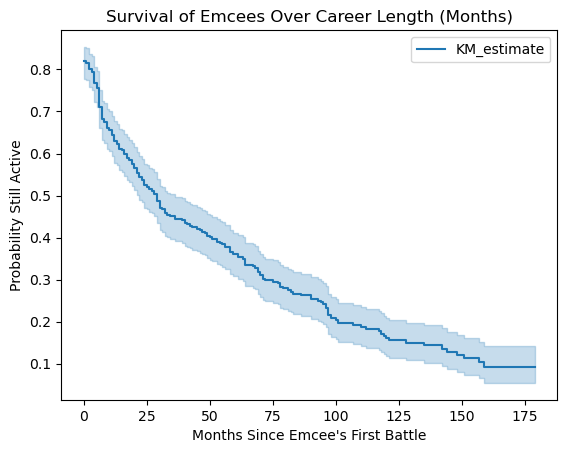

In [ ]:
# from lifelines import KaplanMeierFitter
# import matplotlib.pyplot as plt

# kmf = KaplanMeierFitter()

# # Define survival data
# T = careers["career_length_months"]
# E = careers["inactive"]

# # Fit and plot
# kmf.fit(T, event_observed=E)
# kmf.plot_survival_function()
# plt.title("Survival of Emcees Over Career Length (Months)")
# plt.xlabel("Months Since Emcee's First Battle")
# plt.ylabel("Probability Still Active")
# plt.grid=True
# plt.show()

In [ ]:
# from lifelines import KaplanMeierFitter
# import matplotlib.pyplot as plt

# def plot_km_curve(df, time_col="career_length_months", status_col="status"):
#     # Initialize model
#     kmf = KaplanMeierFitter()

#     # Define duration and event observed
#     durations = df[time_col]
#     event_observed = df[status_col].isin(["inactive", "single-battle-inactive"])

#     # Fit the model
#     kmf.fit(durations, event_observed=event_observed)

#     # Plot
#     plt.figure(figsize=(10,6))
#     ax = kmf.plot(ci_show=True)
#     ax.set_title("Kaplan-Meier estimate of Emcee Career Duration")
#     ax.set_xlabel("Months Since First Recorded Battle")
#     ax.set_ylabel("Probability Emcee Remains Active")
#     ax.set_xticks(
#         range(0, int(durations.max()) + 12, 12) # Yearly intervals
#     )
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import importlib
# importlib.reload(plt)

<module 'matplotlib.pyplot' from 'c:\\Users\\rsl\\miniforge3\\envs\\fliptop-analysis\\Lib\\site-packages\\matplotlib\\pyplot.py'>

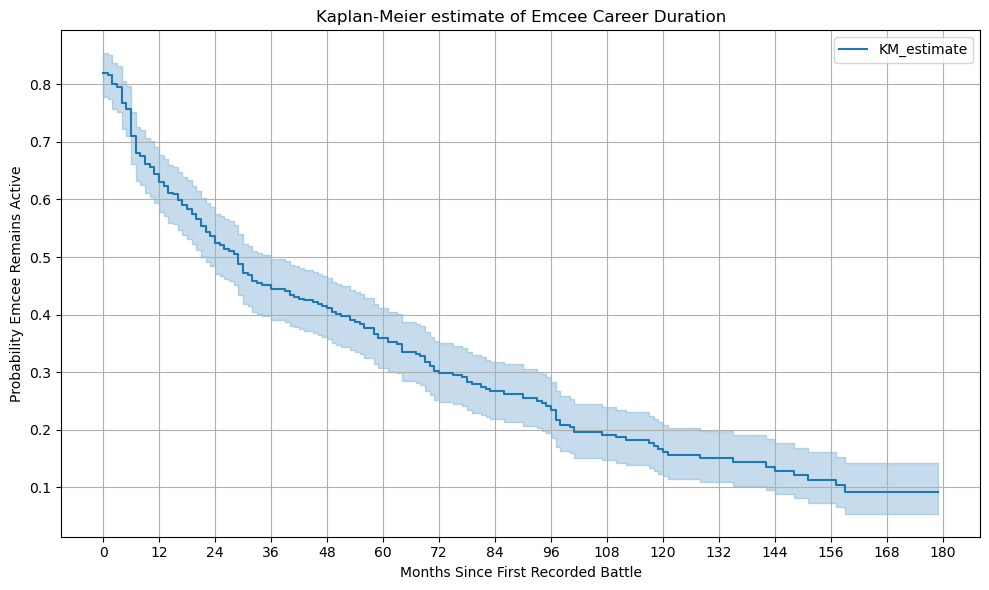

In [ ]:
# plot_km_curve(careers, time_col="career_length_months", status_col="status")

In [ ]:
# careers.head()

,emcee,first_battle,last_battle,battle_count,career_length_months,median_gap_months,mean_gap_months,stdev_gap_months,months_since_last_battle,inactivity_threshold_months,inactive,status,confidence
291,Plazma,2010-05-04 09:48:43+00:00,2025-04-24 12:38:52+00:00,30,179,5.0,6.172414,4.870237,3,11.0,0,active,0.60
143,Harlem,2010-08-21 08:42:09+00:00,2025-03-08 12:43:02+00:00,22,175,4.0,8.333333,9.172422,4,10.0,0,active,1.00
327,Sayadd,2011-01-28 15:10:01+00:00,2025-05-29 11:31:47+00:00,29,172,5.0,6.142857,3.217018,2,11.0,0,active,0.40
334,Shehyee,2010-09-07 08:55:08+00:00,2025-01-05 11:18:54+00:00,17,172,3.5,10.750000,18.968395,6,9.5,0,active,1.71
16,Apoc,2010-05-04 09:48:43+00:00,2024-05-23 12:37:39+00:00,18,168,10.0,9.882353,5.893666,14,16.0,0,active,1.40


In [ ]:
# kmf.median_survival_time_

np.float64(29.0)

50% of all emcees stop doing 1v1 battling (i.e. become inactive) within 29 months of their debut.
- So more than 2 years after their debuts, 50% of emcees drop out of the game.

#### Emcee Career Survival Analysis: Documented Assumptions

1. Defining "Career Start" and "Career Length"

- A career starts at the date of an emcee's first recorded battle (`first_battle`).

- Career length is measured in months, computed as:
    `(last_battle.year - first_battle.year) * 12 + (last_battle.month - first_battle.month)`

2. Gap Statistics Between Battles

For each emcee, the following statistics are computed:
- `median_gap_months`: median time between consecutive battles
- `mean_gap_months`: average time between battles
- `stdev_gap_months`: standard deviation of gap durations

Gaps are measured in months, not days.

3. Defining Inactivity

An emcee is considered inactive if:
- Time since their last battle exceeds their `median_gap_months` plus a buffer of 6 months.
- If the emcee has only 1 battle, or their median gap is zero or missing, the fallback threshold is 24 months.

Explicit thresholds used:
- `fallback_months` = 24
- `buffer_months` = 6

Thus:
- `inactivity_threshold_months = median_gap_months + buffer_months`

4. Emcee Status Classification

Each emcee is assigned a status string for richer diagnostic context:
- `active`: More than one battle and last battle was recent
- `inactive`: More than one battle and last battle was too long ago
- `single-battle-active`: Only one battle, but still recent
- `single-battle-inactive`: Only one battle, and too long ago
- `unknown`: Missing or malformed battle date information

Additionally, a binary inactive column is defined as 1 or 0 based on the threshold logic.


5. Pandemic-Aware Buffering
- The choice of `fallback_months` = 24 is intentionally generous to account for disruption in recorded battles during the COVID-19 pandemic (approximately 2020–2023).
- This helps avoid misclassifying emcees as inactive if their last battle occurred just before or during the pandemic.

6. Survival Analysis Assumptions

- An emcee is considered to have had a career-ending event if their status is either `inactive` or `single-battle-inactive`.
- Emcees with other statuses (`active`, `single-battle-active`, `unknown`) are treated as right-censored in the Kaplan-Meier analysis.
- The survival curve shows the probability that an emcee remains active (not yet inactive) over time in months since their first battle.
- A median survival time of 29 months means that half of emcees remain active at least 29 months into their career.

In [ ]:
# careers.head()

,emcee,first_battle,last_battle,battle_count,career_length_months,median_gap_months,mean_gap_months,stdev_gap_months,months_since_last_battle,inactivity_threshold_months,inactive,status,confidence
291,Plazma,2010-05-04 09:48:43+00:00,2025-04-24 12:38:52+00:00,30,179,5.0,6.172414,4.870237,3,11.0,0,active,0.60
143,Harlem,2010-08-21 08:42:09+00:00,2025-03-08 12:43:02+00:00,22,175,4.0,8.333333,9.172422,4,10.0,0,active,1.00
327,Sayadd,2011-01-28 15:10:01+00:00,2025-05-29 11:31:47+00:00,29,172,5.0,6.142857,3.217018,2,11.0,0,active,0.40
334,Shehyee,2010-09-07 08:55:08+00:00,2025-01-05 11:18:54+00:00,17,172,3.5,10.750000,18.968395,6,9.5,0,active,1.71
16,Apoc,2010-05-04 09:48:43+00:00,2024-05-23 12:37:39+00:00,18,168,10.0,9.882353,5.893666,14,16.0,0,active,1.40
